In [2]:
import sys
sys.path.append('..')
from swdf.utils import *
convert_uuids_to_indices()
import sklearn
from tsai.basics import *
my_setup(sklearn)
from matplotlib import dates as mdates
import wandb
from fastai.callback.wandb import WandbCallback
from fastai.callback.progress import ShowGraphCallback
from swdf.losses import LossFactory
from swdf.metrics import ValidationMetricsHandler, LossMetrics

os              : Linux-6.8.0-41-generic-x86_64-with-glibc2.31
python          : 3.10.12
tsai            : 0.3.10
fastai          : 2.7.15
fastcore        : 1.5.49
sklearn         : 1.5.1
torch           : 2.2.2+cu121
device          : 1 gpu (['NVIDIA GeForce RTX 3070 Ti Laptop GPU'])
cpu cores       : 14
threads per cpu : 1
RAM             : 15.28 GB
GPU memory      : [8.0] GB


In [3]:
# This is only needed for the MIT supercloud, to fix fastai's LRFinder error 
if torch.cuda.is_available() and torch.cuda.device_count() == 0:
    from fastai.callback.schedule import LRFinder

    @patch_to(LRFinder)
    def after_fit(self):
        self.learn.opt.zero_grad() # Needed before detaching the optimizer for future fits
        tmp_f = self.path/self.model_dir/self.tmp_p/'_tmp.pth'
        if tmp_f.exists():
            self.learn.load(f'{self.tmp_p}/_tmp', with_opt=True, device='cpu')
            self.tmp_d.cleanup()

# Training the Geomagnetic Indices Dst and Ap Forecaster

In this notebook, we implement the training process for the forecaster of the Ap and Dst indices together. We use the PatchTST architecture, which has been discussed previously. For further details about the architecture and training process, please refer to the `solfsmy_train` notebook, where a similar approach is followed. Additionally, for more information on these indices, you can consult the `geodst_data` and `geoap_data` notebooks.

The reason for merging these two indices is that they are related, as both measure the same phenomenon. This relationship could allow the model to leverage information from one index to benefit the other. With that in mind, let's dive into the training process.


In [4]:
config_base = yaml2dict('./config/base.yaml', attrdict=True)
config_dstap = yaml2dict('./config/geodstap.yaml', attrdict=True)
config_train = config_dstap.train
config_data = config_dstap.data

# Merge the two configs (the second one overrides the first one for any keys that are present in both)
config = AttrDict({**config_base,
                   **config_train, 
                   "data":AttrDict({**config_data})})

# Add the architecture config
if config.arch_name.lower() == 'patchtst':
    config.arch = yaml2dict('./config/patchtst.yaml', attrdict=True)
else:
    config.arch = AttrDict()

In [5]:
run = wandb.init(project=config.wandb.project, 
                 config=config,
                 group=config.wandb.group,
                 mode=config.wandb.mode, 
                 anonymous='never') if config.wandb.enabled else None
config = dict2attrdict(run.config) if config.wandb.enabled else config

In [6]:
config

```json
{ 'arch': { 'd_model': 1024,
            'decomposition': True,
            'dropout': 0.4,
            'individual': True,
            'n_heads': 16,
            'padding_patch': True,
            'revin': True},
  'arch_config_file': 'config/patchtst.yaml',
  'arch_name': 'PatchTST',
  'bs': 128,
  'data': { 'add_time_channels': False,
            'ap_config': './config/geoap.yaml',
            'data_columns': ['DST', 'AP'],
            'data_nb': './geodstap_data.ipynb',
            'df_save_path': './preprocessed_data/dataframes/geodstap.pkl',
            'dst_config': './config/geodst.yaml',
            'exp_pipe_save_path': './preprocessed_data/pipelines/exp_geodstap.pkl',
            'preproc_pipe_save_path': './preprocessed_data/pipelines/preproc_geodstap.pkl'},
  'horizon': 24,
  'init_weights': False,
  'is_optuna_study': False,
  'lookback': 96,
  'loss_config': {},
  'loss_func': 'wMSE',
  'lr_max': None,
  'main_metric': 'default',
  'metrics_handler_path': None,
  'n_epoch': 30,
  'partial_n': 0.1,
  'seed': 42,
  'test_end_datetime': '2018-12-31 12:00:00',
  'test_start_datetime': '2012-10-01 12:00:00',
  'valid_start_datetime': '2018-01-01 12:00:00',
  'wandb': { 'enabled': False,
             'group': None,
             'log_learner': True,
             'mode': 'offline',
             'project': 'swdf'}}
```

In [7]:
df, preproc_pipe, exp_pipe = generate_preprocessed_data(config.data)

df.head()

,Datetime,DST,AP
0,1957-01-01 00:00:00,12.0,2
1,1957-01-01 03:00:00,9.3,3
2,1957-01-01 06:00:00,5.0,3
3,1957-01-01 09:00:00,-5.0,22
4,1957-01-01 12:00:00,0.0,15


The data columns configuration is determined by the strategy chosen to address the resolution discrepancy between the indices:

- **If Adding Time-Related Data:** When the strategy is to maintain the original distribution of both indices, time-related data (such as Day of Year, DOY) is required.

- **If Downgrading Dst Resolution:** If the Dst resolution is downgraded to match the Ap 3-hour distribution, this simplifies computation, and the configuration may not require time-related data.


In [8]:
data_columns = config.data.data_columns + ['DOY'] if config.data.add_time_channels else config.data.data_columns

## Data Splitting

In this case, we have significantly more data than when forecasting the FSMY 10.7 solar indices, as we have older data from both indices (dating back to 1957) and a much higher resolution (8 measurements per day). Therefore, we did not need to use more complex data splitting strategies. We simply selected a test period, with the period before it as the training set, and the period after it (the most recent values) as the validation set.

We have again used the test period from [Licata et al. (2020)](https://agupubs.onlinelibrary.wiley.com/doi/pdf/10.1029/2020SW002496), as we want to compare our results with theirs. They used data from **October 2012 through the end of 2018** for benchmarking.


In [9]:
test_start_datetime = config.test_start_datetime
test_end_datetime = config.test_end_datetime
valid_start_datetime = config.valid_start_datetime

In the case of these two geomagnetic indices, the benchmark authors classify them in different ranges of activity levels. Those levels are listed right below:

### Ap Index Categories and Thresholds

| **Category** | **Threshold** |
|--------------|-----------------------|
| Low          | Less than 10          |
| Moderate     | 10 to 50              |
| Active       | 50 to 9999            |

### Dst Index Categories and Thresholds

| **Category** | **Threshold** |
|--------------|-----------------------|
| G0           | -30 or More           |
| G1           | -50 to -30            |
| G2           | -90 to -50            |
| G3           | -130 to -90           |
| G4           | -350 to -130          |
| G5           | Less than -350        |


In [10]:
thresholds = {
    "AP": [
        (-np.inf, 10),  # Low
        (10, 50),    # Moderate
        (50, np.inf)   # Active
    ],
    "DST": [
        (-30, np.inf),    # G0
        (-50, -30),     # G1
        (-90, -50),     # G2
        (-130, -90),    # G3
        (-350, -130),   # G4
        (-np.inf, -350)    # G5
    ]
}

activity_levels = {
    'AP': ["Low", "Moderate", "Active"],
    'DST': ["G0", "G1", "G2", "G3", "G4", "G5"]
}

In [11]:
dict2yaml(thresholds, 'preprocessed_data/categorization/thresholds_geodstap.yaml')
dict2yaml(activity_levels, 'preprocessed_data/categorization/activity_levels_geodstap.yaml')

The resulting splits are plotted below:


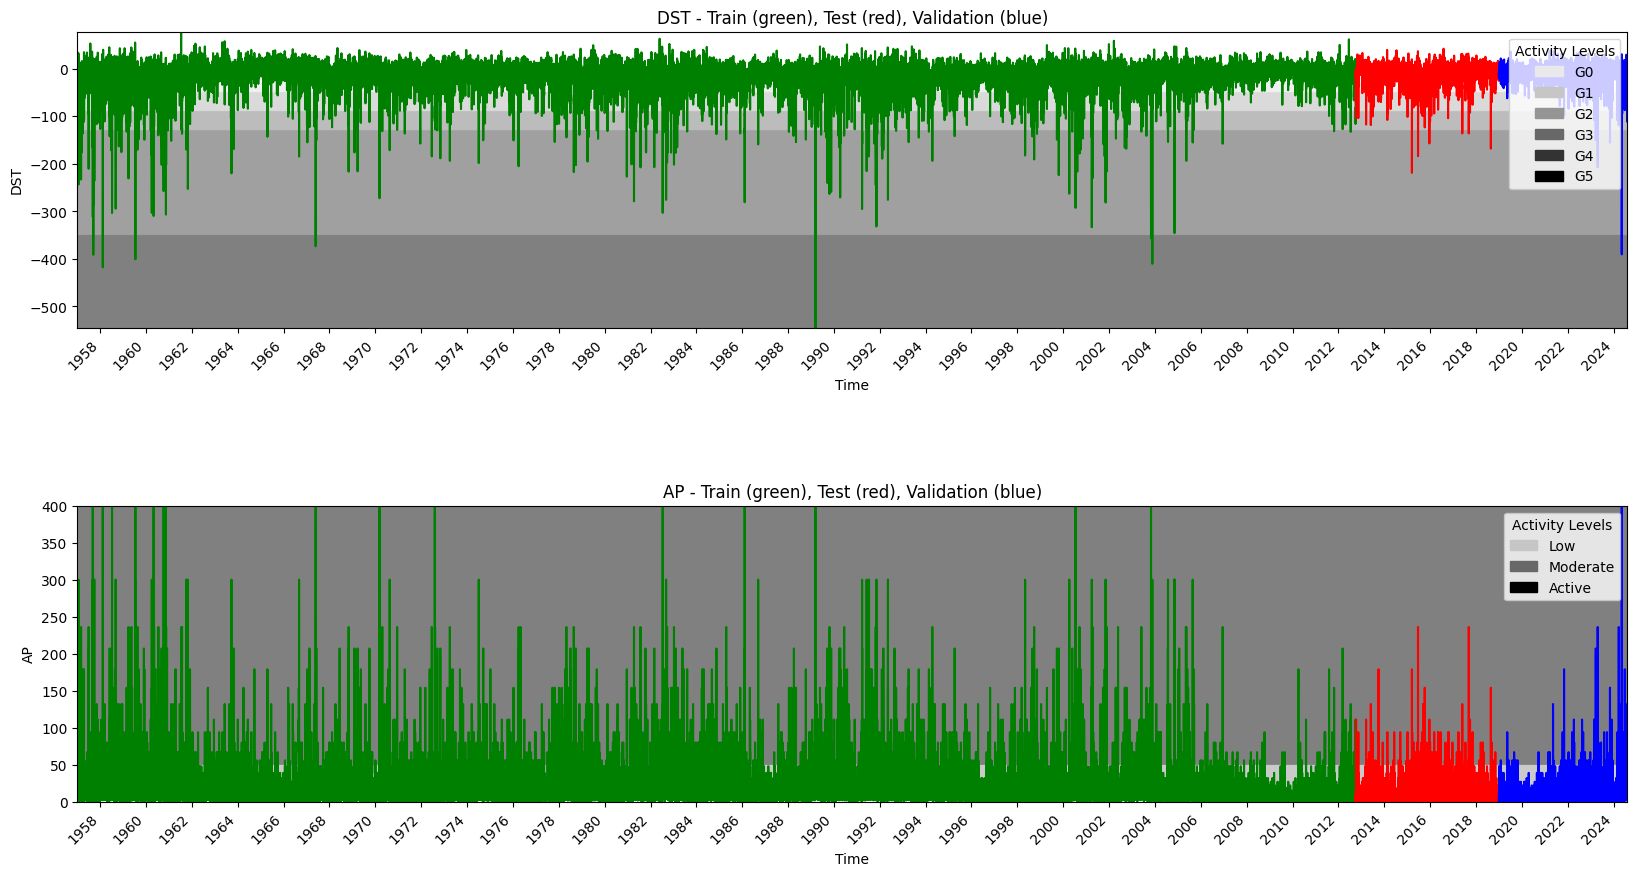

In [12]:
import matplotlib.patches as mpatches
import matplotlib.dates as mdates
import numpy as np
import matplotlib.pyplot as plt

# Create the subplots
fig, ax = plt.subplots(2, 1, figsize=(20, 10))
plt.subplots_adjust(hspace=0.6)

# Loop over the data columns to plot the main time series with shaded regions for train, test, validation
for i, value in enumerate(config.data.data_columns):
    # Scatter plot for train, test, validation with different colors
    ax[i].plot(df.Datetime[(df.Datetime < test_start_datetime)], 
                  df[value][(df.Datetime < test_start_datetime)], label='Train', color='green')
    
    ax[i].plot(df.Datetime[(df.Datetime >= test_start_datetime) & (df.Datetime <= test_end_datetime)], 
                  df[value][(df.Datetime >= test_start_datetime) & (df.Datetime <= test_end_datetime)], label='Test', color='red')
    
    ax[i].plot(df.Datetime[(df.Datetime > test_end_datetime)], 
                  df[value][(df.Datetime > test_end_datetime)], label='Validation', color='blue')
    
    # Apply the thresholds for the specific variable
    min_val, max_val = df[value].min(), df[value].max()
    set_ranges = np.zeros((df.shape[0], int(max_val - min_val)))

    for j, (start, end) in enumerate(thresholds[value]):
        start = -99999 if np.abs(start) == np.inf else start
        end = 99999 if np.abs(end) == np.inf else end

        mask = (df[value] >= start) & (df[value] < end)
        set_ranges[:, int(start - min_val):int(end - min_val)] = ((j + 1) / len(thresholds[value]))
    
    # Apply the 'Greys' colormap
    ax[i].imshow(set_ranges.T, extent=[df.Datetime.min(), df.Datetime.max(), min_val, max_val],
                 aspect='auto', alpha=0.5, origin='lower', cmap='Greys')

    # Title and labels
    ax[i].set_title(f'{value} - Train (green), Test (red), Validation (blue)')
    ax[i].set_xlabel('Time')
    ax[i].set_ylabel(value)

    # Format x-axis to show only the years
    ax[i].xaxis.set_major_locator(mdates.YearLocator(2))
    ax[i].xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    plt.setp(ax[i].get_xticklabels(), rotation=45, ha="right")

    # Create legend for activity levels
    legend_labels = activity_levels[value]
    colors = [plt.cm.Greys((j + 1) / len(legend_labels)) for j in range(len(legend_labels))]
    patches = [mpatches.Patch(color=colors[j], label=legend_labels[j]) for j in range(len(legend_labels))]
    ax[i].legend(handles=patches, loc='upper right', title='Activity Levels')

# Show the plot
plt.show()


Now we will generate the split indexes for each of the sets we mentioned earlier. To do this, we will use the `tsai` function `get_forecasting_splits`, which automatically creates the splits. However, since this function determines the size of the splits using percentages of the dataset rather than specific dates, we have implemented a workaround.


In [13]:
# Test and Training sets generation
splits_ = get_forecasting_splits(
    df[df.Datetime < valid_start_datetime], 
    fcst_history=config.lookback, 
    fcst_horizon=config.horizon, 
    use_index=False, 
    test_cutoff_datetime=test_start_datetime, 
    show_plot=False, 
    datetime_col='Datetime'
)

# Validation set generation
validation_data = df[df.Datetime >= valid_start_datetime]

validation_splits = get_forecasting_splits(
    validation_data, 
    fcst_history=config.lookback, 
    fcst_horizon=config.horizon, 
    valid_size=0.0, 
    test_size=0.0, 
    show_plot=False
)

val_idxs = L(validation_data.index[validation_splits[0]].tolist())

# Combination of the different set
splits = (splits_[0], val_idxs, splits_[1])
splits


((#162782) [0,1,2,3,4,5,6,7,8,9...],
 (#19160) [178244,178245,178246,178247,178248,178249,178250,178251,178252,178253...],
 (#15320) [162805,162806,162807,162808,162809,162810,162811,162812,162813,162814...])

In [14]:
# We'll approach the time series forecasting task as a supervised learning problem. 
# Remember that tsai requires that both inputs and outputs have the following shape:
# (samples, features, steps)

# To get those inputs and outputs we're going to use a function called 
# `prepare_forecasting_data`` that applies a sliding window along the dataframe
X, y = prepare_forecasting_data(df, fcst_history=config.lookback, 
                                fcst_horizon=config.horizon,
                                x_vars=config.data.data_columns, 
                                y_vars=config.data.data_columns)

X.shape, y.shape

((197404, 2, 96), (197404, 2, 24))

## Training the Forecaster

This section implements the entire training process for the forecasting model.

### Generate Weights

Although we are not dealing with an imbalanced training set like in the FSMY 10.7 forecaster (see the `solfsmy_train` notebook), the values are still not equally distributed across all solar activity levels. To address this, we assign weights to the training process using the inverse frequency of each level. By doing so, errors in forecasting the less represented values will be more heavily penalized.


In [15]:
df_cat = get_classified_columns(df, thresholds, activity_levels)

def get_weights(column:pd.Series):
    distribution = column.value_counts(normalize=True).to_dict()
    inverted_weights = {category: 1 / frequency for category, frequency in distribution.items()}
    total_weight = sum(inverted_weights.values())
    normalized_weights = [weight / total_weight for weight in inverted_weights.values()]
    return normalized_weights

weights = {
    column: get_weights(df_cat[df.Datetime < test_start_datetime][f'{column}_Cat'])
    for column in config.data.data_columns
}

weights

{'DST': [8.803351903177007e-05,
  0.0006020729557296344,
  0.0014018781299297467,
  0.007761028027872513,
  0.01549121753377997,
  0.9746557698336564],
 'AP': [0.05027553210414406, 0.08743208708643083, 0.862292380809425]}

In [16]:
save_object(weights, 'preprocessed_data/weights/weights_geodstap.pkl')

preprocessed_data/weights directory created.
dict saved as preprocessed_data/weights/weights_geodstap.pkl


epoch,train_loss,valid_loss,Loss_Low,Loss_Medium,Loss_Active,Loss_G0,Loss_G1,Loss_G2,Loss_G3,Loss_G4,Loss_G5,time
0,13.114963,6.246802,5.572682,0.667330,0.000000,0.006791,0.000000,0.000000,0.000000,0.000000,0.000000,00:24
1,12.784650,6.163347,5.500598,0.656166,0.000000,0.006583,0.000000,0.000000,0.000000,0.000000,0.000000,00:25
2,12.335350,6.345724,5.673854,0.665265,0.000000,0.006604,0.000000,0.000000,0.000000,0.000000,0.000000,00:25
3,12.013974,6.179952,5.588273,0.584958,0.000000,0.006720,0.000000,0.000000,0.000000,0.000000,0.000000,00:25
4,11.551650,6.130228,5.491984,0.630905,0.000000,0.007338,0.000000,0.000000,0.000000,0.000000,0.000000,00:25
5,11.417176,6.113671,5.542159,0.563820,0.000000,0.007692,0.000000,0.000000,0.000000,0.000000,0.000000,00:25
6,11.279366,6.019103,5.358129,0.651614,0.000000,0.009360,0.000000,0.000000,0.000000,0.000000,0.000000,00:26
7,11.127131,6.132680,5.452404,0.659248,0.000000,0.021029,0.000000,0.000000,0.000000,0.000000,0.000000,00:26
8,11.104568,6.140027,5.597128,0.532442,0.000000,0.010458,0.000000,0.000000,0.000000,0.000000,0.000000,00:26
9,11.634913,6.300477,5.739375,0.550802,0.000000,0.010298,0.000000,0.000000,0.000000,0.000000,0.000000,00:26


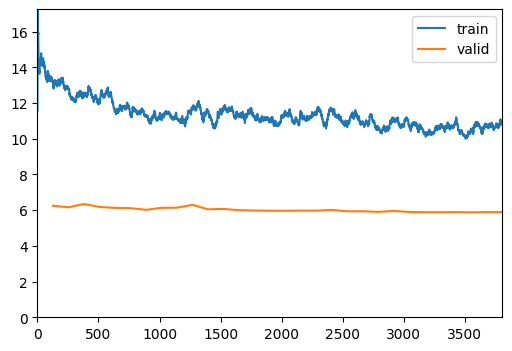

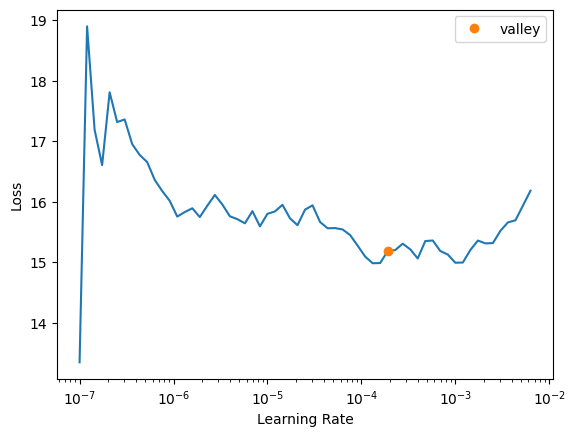

In [16]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Initialize the loss function with the provided thresholds and weights
loss = LossFactory(thresholds=thresholds, weights=weights).create(
    config.loss_func, **config.loss_config
).to(device)

# Set up metrics 
if config.metrics_handler_path is not None:
    metrics_handler = load_object(config.metrics_handler_path)
else:
    metrics_handler = LossMetrics(loss, 'GeoDSTAP')
metrics = metrics_handler.get_metrics()

# Initialize the callback list, including WandbCallback if enabled
wandb_callback = WandbCallback(log_preds=False)
callbacks = L(wandb_callback) if config.wandb.enabled else L()
callbacks += ShowGraphCallback()

learn = TSForecaster(
    X, y, splits=splits, 
    batch_size=config.bs,
    pipelines=[preproc_pipe, exp_pipe], 
    arch=config.arch_name, 
    metrics=metrics,
    loss_func=loss,
    arch_config=dict(config.arch), 
    init=config.init_weights,
    cbs= callbacks, 
    partial_n=config.partial_n)
learn.to(device)

try: # In some extreme cases it can fail and return an error
    lr_max = learn.lr_find().valley if config.lr_max is None else config.lr_max
except:
    lr_max = 1e-3

learn.fit_one_cycle(n_epoch=config.n_epoch, lr_max=lr_max)

## Model Saving

In [17]:
if config.metrics_handler_path is not None:
    valid_metrics = learn.recorder.metrics 
else:
    valid_metrics = [AttrDict({
        "name": config.loss_func,
        "value": learn.validate()[0]
    })]

%store valid_metrics

print({metric.name: metric.value for metric in valid_metrics})

Stored 'valid_metrics' (list)
{'wMSE': 5.892127513885498}


In [18]:
learn.dls.loaders += [learn.dls.valid.new_dl(X[splits[2]], y[splits[2]])] 

# Remove the wandb callback to avoid errors when downloading the learner
if config.wandb.enabled:
    learn.remove_cb(wandb_callback)

# Log the test loss to wandb
test_loss = learn.validate(ds_idx=2)[0]

print(test_loss)
if run is not None:
    run.log(dict(test_loss=test_loss))

6.272867202758789


In [22]:
best_valid_metrics = None
%store -r best_valid_metrics

save_all_or_best = (
    config.is_optuna_study and 
    metrics_handler.are_best_values(best_valid_metrics, valid_metrics)
) or not config.is_optuna_study

if save_all_or_best:
    best_valid_metrics = valid_metrics
    %store best_valid_metrics                                            

    # Save locally and in wandb if online and enabled
    learn.save_all(path='tmp', verbose=True, model_fname='model_geodstap', learner_fname="learner_geodstap") 
    if run is not None and config.wandb_mode and config.wandb_log_learner:
        # Save the learner (all tmp/dls, tmp/model.pth, and tmp/learner.pkl). 
        run.log_artifact('tmp', type='learner', name='geodstap')
    
    # Save the best model
    model = {}
    model['models'] = [learn.model]
    model['lookback'] = config.lookback
    model['horizon'] = config.horizon
    model['data_columns'] = data_columns
    model['thresholds'] = thresholds

    torch.save(model, 'models/best/best_model_geodstap.pth')

Stored 'best_valid_metrics' (list)
Learner saved:
path          = 'tmp'
dls_fname     = '['dls_0.pth', 'dls_1.pth', 'dls_2.pth', 'dls_3.pth']'
model_fname   = 'model_geodstap.pth'
learner_fname = 'learner_geodstap.pkl'


In [20]:
# Log the test loss to wandb
test_loss = learn.validate(ds_idx=2)[0]
print(test_loss)
if run is not None:
    run.log(dict(test_loss=test_loss))

6.272867202758789


In [21]:
if run is not None:
    run.finish()